In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.cuda.amp import autocast, GradScaler
import time
import math
import copy

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_dataset = datasets.ImageFolder(root="/kaggle/input/pest-training/Training_Data/Training_Data", transform=transform)
val_dataset = datasets.ImageFolder(root="/kaggle/input/pest-training/Validation_Data/Validation_Data", transform=transform)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [3]:
class Densenet201Model(nn.Module):
    def __init__(self, num_classes=22):
        super(Densenet201Model, self).__init__()
        self.densenet = models.densenet201(pretrained=True)

        # Replace the Densenet classifier with a fully connected layer
        self.fc = nn.Linear(in_features=self.densenet.classifier.in_features, 
                            out_features=num_classes)
        self.densenet.classifier = nn.Identity()  # Remove the default linear layer

    def forward(self, x):
        x = self.densenet(x)  # Pass through Densenet
        x = self.fc(x)  # Pass through the new fully connected layer
        return x


In [4]:
num_classes = 22
learning_rate = 0.001
num_epochs = 40
patience = 40

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Densenet201Model(num_classes=22)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Initialize GradScaler for mixed precision training
scaler = torch.cuda.amp.GradScaler()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 143MB/s] 
/tmp/ipykernel_30/1747793688.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.

In [6]:
# Early stopping variables
best_model = copy.deepcopy(model)
best_acc = 0.0
epochs_no_improve = 0
train_acc_history = []
val_acc_history = []

# Training and validation loop
for epoch in range(num_epochs):
    start_time = time.time()

    print(f'Epoch {epoch+1}/{num_epochs}')
    
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass with autocast (mixed precision)
        optimizer.zero_grad()
        with autocast():  # Enable mixed precision
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Backward pass and optimization
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    train_acc_history.append(train_acc)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass with autocast (mixed precision)
            with autocast():  # Enable mixed precision during validation
                outputs = model(images)
                loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    val_acc_history.append(val_acc)

    # Print accuracy and timing
    epoch_time = (time.time() - start_time) / 60
    print(f'Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}, Time: {epoch_time:.2f} min')

    # Early stopping check
    if val_acc > best_acc:
        best_acc = val_acc
        best_model = copy.deepcopy(model)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered")
        break





Epoch 1/40


/tmp/ipykernel_30/1988355712.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed precision
/tmp/ipykernel_30/1988355712.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed precision during validation


Train Accuracy: 0.7891, Val Accuracy: 0.8342, Time: 8.22 min
Epoch 2/40
Train Accuracy: 0.8606, Val Accuracy: 0.8558, Time: 8.13 min
Epoch 3/40
Train Accuracy: 0.8891, Val Accuracy: 0.8399, Time: 8.12 min
Epoch 4/40
Train Accuracy: 0.9109, Val Accuracy: 0.8768, Time: 8.12 min
Epoch 5/40
Train Accuracy: 0.9290, Val Accuracy: 0.8841, Time: 8.13 min
Epoch 6/40
Train Accuracy: 0.9374, Val Accuracy: 0.8848, Time: 8.13 min
Epoch 7/40
Train Accuracy: 0.9485, Val Accuracy: 0.8853, Time: 8.13 min
Epoch 8/40
Train Accuracy: 0.9558, Val Accuracy: 0.8896, Time: 8.14 min
Epoch 9/40
Train Accuracy: 0.9590, Val Accuracy: 0.9122, Time: 8.13 min
Epoch 10/40
Train Accuracy: 0.9658, Val Accuracy: 0.9217, Time: 8.15 min
Epoch 11/40
Train Accuracy: 0.9653, Val Accuracy: 0.9148, Time: 8.13 min
Epoch 12/40
Train Accuracy: 0.9698, Val Accuracy: 0.9197, Time: 8.12 min
Epoch 13/40
Train Accuracy: 0.9738, Val Accuracy: 0.9087, Time: 8.14 min
Epoch 14/40
Train Accuracy: 0.9747, Val Accuracy: 0.9235, Time: 8.13 mi

In [7]:
# Save the best model
torch.save(best_model, 'bestDensenet201.pth')

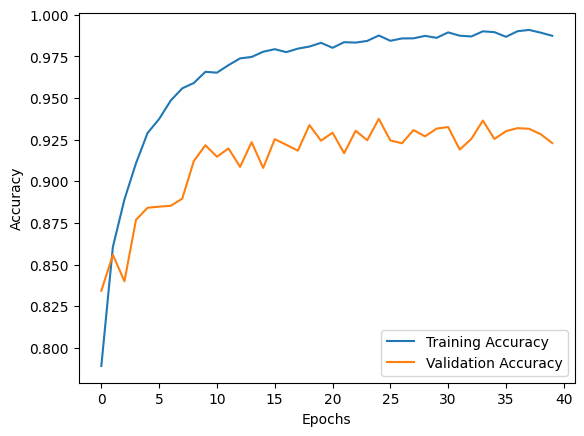

In [8]:
import matplotlib.pyplot as plt
# Plot training vs validation accuracy
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()